# Advice for applying Machine Learning

This post is based on a tutorial given in a machine learning course at University of Bremen. It summarizes some recommendations on how to get started with machine learning on a new problem. This includes

 * ways of visualizing your data
 * choosing a machine learning method suitable for the problem at hand
 * identifying and dealing with over- and underfitting
 * dealing with large (read: not very small) datasets
 * pros and cons of different loss functions.

The post is based on ["Advice for applying Machine Learning"](http://see.stanford.edu/materials/aimlcs229/ML-advice.pdf) from Andrew Ng. The purpose of this notebook is to illustrate the ideas in an interactive way. Some of the recommendations are debatable. Take them as suggestions, not as strict rules.

In [1]:
import time
import numpy as np
np.random.seed(0)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# <!-- collapse=True -->

# Modified from http://scikit-learn.org/stable/auto_examples/plot_learning_curve.html
from sklearn.learning_curve import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

### Dataset

We will generate some simple toy data using [sklearn](http://scikit-learn.org)'s `make_classification` function:

In [4]:
from sklearn.datasets import make_classification
X, y = make_classification(1000, n_features=20, n_informative=2, 
                           n_redundant=2, n_classes=2, random_state=0)

from pandas import DataFrame
df = DataFrame(np.hstack((X, y[:, None])), 
               columns = range(20) + ["class"])

Notice that we generate a dataset for binary classification consisting of 1000 datapoints and 20 feature dimensions. We have used the `DataFrame` class from [pandas](http://pandas.pydata.org/) to encapsulate the data and the classes into one joint data structure. Let's take a look at the first 5 datapoints:

In [5]:
df[:5]

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,class
0,-1.063780,0.676409,1.069356,-0.217580,0.460215,-0.399167,-0.079188,1.209385,-0.785315,-0.172186,...,-0.993119,0.306935,0.064058,-1.054233,-0.527496,-0.074183,-0.355628,1.057214,-0.902592,0
1,0.070848,-1.695281,2.449449,-0.530494,-0.932962,2.865204,2.435729,-1.618500,1.300717,0.348402,...,0.225324,0.605563,-0.192101,-0.068027,0.971681,-1.792048,0.017083,-0.375669,-0.623236,1
2,0.940284,-0.492146,0.677956,-0.227754,1.401753,1.231653,-0.777464,0.015616,1.331713,1.084773,...,-0.050120,0.948386,-0.173428,-0.477672,0.760896,1.001158,-0.069464,1.359046,-1.189590,1
3,-0.299517,0.759890,0.182803,-1.550233,0.338218,0.363241,-2.100525,-0.438068,-0.166393,-0.340835,...,1.178724,2.831480,0.142414,-0.202819,2.405715,0.313305,0.404356,-0.287546,-2.847803,1
4,-2.630627,0.231034,0.042463,0.478851,1.546742,1.637956,-1.532072,-0.734445,0.465855,0.473836,...,-1.061194,-0.888880,1.238409,-0.572829,-1.275339,1.003007,-0.477128,0.098536,0.527804,0


It is hard to get any clue of the problem by looking at the raw feature values directly, even on this low-dimensional example. Thus, there is a wealth of ways of providing more accessible views of your data; a small subset of these is discussed in the next section.

### Visualization

First step when approaching a new problem should nearly always be **visualization**, i.e., looking at your data.

[Seaborn](http://stanford.edu/~mwaskom/software/seaborn/) is a great package for statistical data visualization. We use some of its functions to explore the data.

First step is to generate scatter-plots and histograms using the `pairplot`. The two colors correspond to the two classes and we use a subset of the features and only the first 50 datapoints to keep things simple.

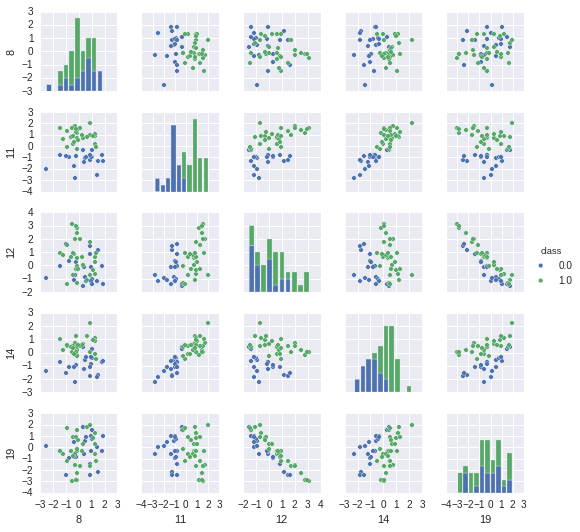

In [6]:
_ = sns.pairplot(df[:50], vars=[8, 11, 12, 14, 19], hue="class", size=1.5)

Based on the histograms, we can see that some features are more helpful to distinguish the two classes than other. In particular, feature 11 and 14 seem to be informative. The scatterplot of those two features shows that the classes are almost linearly separable in this 2d space. A further thing to note is that feature 12 and 19 are highly anti-correlated. We can explore correlations more systematically by using `corrplot`:

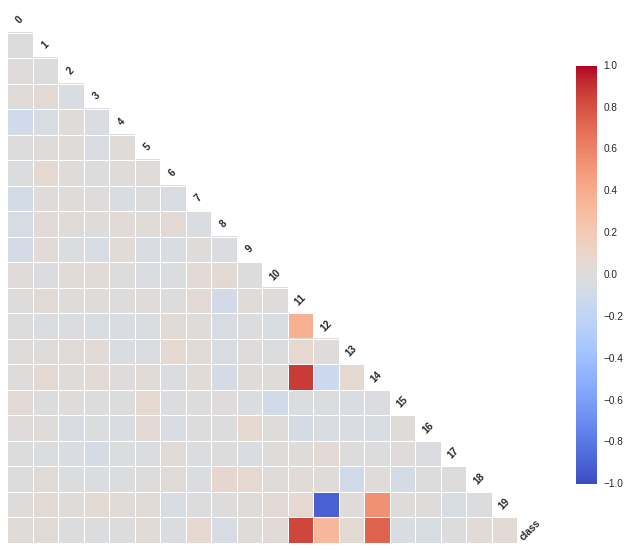

In [7]:
plt.figure(figsize=(12, 10))
_ = sns.corrplot(df, annot=False)

We can see our observations from before confirmed here: feature 11 and 14 are strongly correlated with the class (they are informative). They are also strongly correlated with each other (via the class). Furthermore, feature 12 is highly anti-correlated with feature 19, which in turn is correlated with feature 14. We have thus some redundant features. This can be problematic for some classifiers, e.g., naive Bayes which assumes the features being independent given the class. The remaining features are mostly noise; they are neither correlated with each other nor with the class.

Notice that data visualization becomes more challenging if you have more feature dimensions and less datapoints. We give an example for visualiszing high-dimensional data later.

### Choice of the method

Once we have visually explored the data, we can start applying machine learning to it. Given the wealth of methods for machine learning, it is often not easy to decide which method to try first. This simple cheat-sheet (credit goes to [Andreas Müller](http://peekaboo-vision.blogspot.de/2013/01/machine-learning-cheat-sheet-for-scikit.html) and the [sklearn-team](http://scikit-learn.org/stable/tutorial/machine_learning_map/)) can help to select an appropriate ML method for your problem (see http://dlib.net/ml_guide.svg for an alternative cheat sheet).

In [1]:
from IPython.display import Image
Image(filename='ml_map.png', width=800, height=600) 

IOError: [Errno 2] No such file or directory: u'ml_map.png'

Since we have 1000 samples, are predicting a category, and have labels, the sheet recommends that we use a `LinearSVC` (which stands for support vector classification with linear kernel and uses an efficient algorithm for solving this particular problem) first. So we give it a try. `LinearSVC` requires to select the regularization; we use the standard L2-norm penalty and C=10. We plot a learning curve for both the training score and the validation score (score corresponds to accuracy in this case):

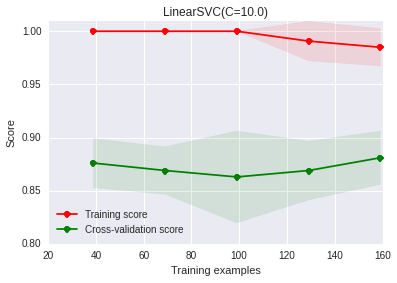

In [9]:
from sklearn.svm import LinearSVC
plot_learning_curve(LinearSVC(C=10.0), "LinearSVC(C=10.0)",
                    X, y, ylim=(0.8, 1.01),
                    train_sizes=np.linspace(.05, 0.2, 5))

We can notice that there is a large gap between error on training and on validation data. What does that mean? We are probably **overfitting** the training data!

### Adressing overfitting

There are different ways to decreasing overfitting:
 * **increase number of training examples** (getting more data is common wish of machine learning practitioners)

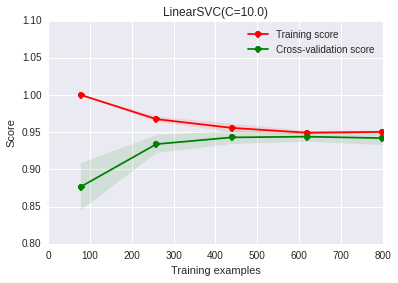

In [10]:
plot_learning_curve(LinearSVC(C=10.0), "LinearSVC(C=10.0)",
                    X, y, ylim=(0.8, 1.1),
                    train_sizes=np.linspace(.1, 1.0, 5))

We see that our validation score becomes larger with more data and the gap closes; thus we are now longer overfitting. There are different ways of obtaining more data, for instance we (a) might invest the effort of collecting more, (b) create some artificially based on the existing ones (for images, e.g., rotation, translation, distortion), or (c) add artificial noise.

If none of these approaches is applicable and thus more data would not be available, we could alternatively 

 * **decrease the number of features** (we know from our visualizations that features 11 and 14 are most informative)

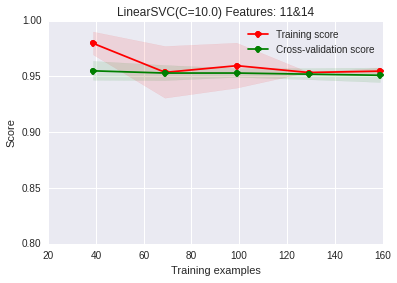

In [11]:
plot_learning_curve(LinearSVC(C=10.0), "LinearSVC(C=10.0) Features: 11&14",
                    X[:, [11, 14]], y, ylim=(0.8, 1.0),
                    train_sizes=np.linspace(.05, 0.2, 5))

Note that this is a bit cheating since we have selected the features manually and on more data than we gave the classifier. We could use automatic feature selection alternatively:

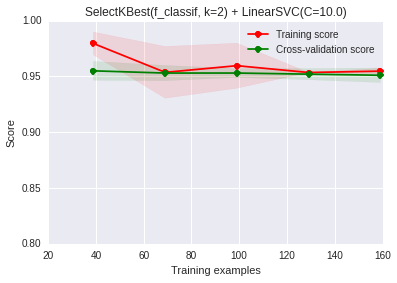

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
# SelectKBest(f_classif, k=2) will select the k=2 best features according to their Anova F-value

plot_learning_curve(Pipeline([("fs", SelectKBest(f_classif, k=2)), # select two features
                               ("svc", LinearSVC(C=10.0))]),
                    "SelectKBest(f_classif, k=2) + LinearSVC(C=10.0)",
                    X, y, ylim=(0.8, 1.0),
                    train_sizes=np.linspace(.05, 0.2, 5))

This worked remarkably well. Feature selection is simple on this toy data. It should be noted that feature selection is only one special kind of reducing the model's complexity. Others would be: (a) reduce the degree of a polynomial model in linear regression, (b) reduce the number of nodes/layers of an artificial neural network, (c) increase bandwidth of an RBF-kernel etc.

One question remains: why can't the classifier identify the useful features on its own? Let's first turn to a further alternative to decrease overfitting:

 * **increase regularization of classifier** (decrease parameter C of Linear SVC)

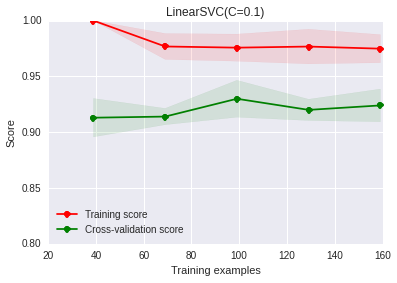

In [13]:
plot_learning_curve(LinearSVC(C=0.1), "LinearSVC(C=0.1)", 
                    X, y, ylim=(0.8, 1.0),
                    train_sizes=np.linspace(.05, 0.2, 5))

This already helped a bit. We can also select the regularization of the classifier automatically using a grid-search based on cross-validation:

Chosen parameter on 100 datapoints: {'C': 0.01}


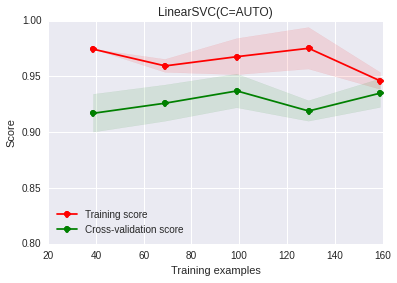

In [14]:
from sklearn.grid_search import GridSearchCV
est = GridSearchCV(LinearSVC(), 
                   param_grid={"C": [0.001, 0.01, 0.1, 1.0, 10.0]})
plot_learning_curve(est, "LinearSVC(C=AUTO)", 
                    X, y, ylim=(0.8, 1.0),
                    train_sizes=np.linspace(.05, 0.2, 5))
print "Chosen parameter on 100 datapoints: %s" % est.fit(X[:100], y[:100]).best_params_

In general, feature selection looked better. Can the classifier identify useful features on its own? Recall that LinearSVC also supports the l1 penalty, which results in sparse solutions. Sparse solutions correspond to an implicit feature selection. Let's try this:

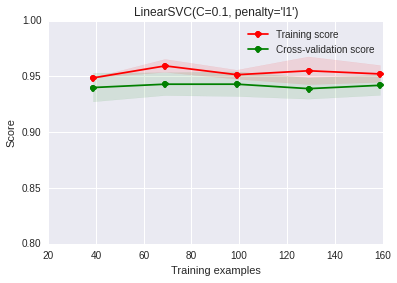

In [15]:
plot_learning_curve(LinearSVC(C=0.1, penalty='l1', dual=False), 
                    "LinearSVC(C=0.1, penalty='l1')", 
                    X, y, ylim=(0.8, 1.0),
                    train_sizes=np.linspace(.05, 0.2, 5))

This also looks quite well. Let's investigate the coefficients learned:

In [16]:
est = LinearSVC(C=0.1, penalty='l1', dual=False)
est.fit(X[:150], y[:150])  # fit on 150 datapoints
print "Coefficients learned: %s" % est.coef_
print "Non-zero coefficients: %s" % np.nonzero(est.coef_)[1]

Coefficients learned: [[ 0.          0.          0.          0.          0.          0.01857999
   0.          0.          0.          0.004135    0.          1.05241369
   0.01971419  0.          0.          0.          0.         -0.05665314
   0.14106505  0.        ]]
Non-zero coefficients: [ 5  9 11 12 17 18]


Most coefficients are zero (the corresponding feature was ignored) and by far the strongest weight is put onto feature 11.

### A different dataset

We generate another dataset for binary classification and apply a `LinearSVC` again.

In [17]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000, random_state=2)

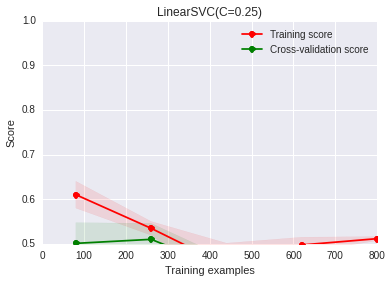

In [18]:
plot_learning_curve(LinearSVC(C=0.25), "LinearSVC(C=0.25)", 
                    X, y, ylim=(0.5, 1.0),
                    train_sizes=np.linspace(.1, 1.0, 5))

Wow, that was very bad, even the training error is not better than random. What is a possible reason for this? Would any of the above recipes (more data, feature selection, increase regularization) help? 

Turns out: No. We are in a completely different situation: Before, the training score was always close to perfect and we had to address overfitting. This time, training error is also very low. We are **underfitting**. Let us take a look at the data:

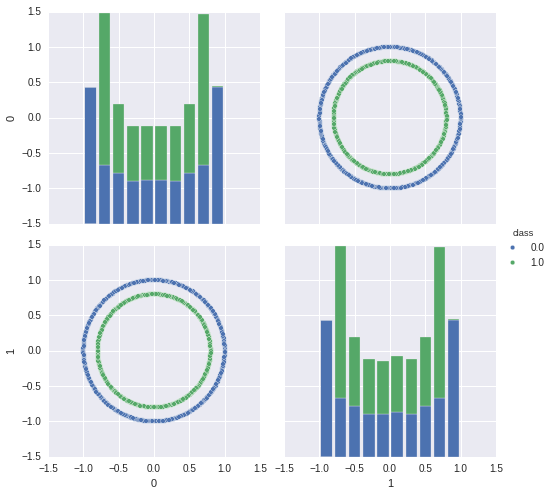

In [19]:
df = DataFrame(np.hstack((X, y[:, None])), 
               columns = range(2) + ["class"])
_ = sns.pairplot(df, vars=[0, 1], hue="class", size=3.5)

This data is clearly not linearly separable; more data or less features cannot help. Our model is wrong; thus the underfitting.

### Adressing underfitting

Ways to decrease underfitting:
 * **use more or better features** (the distance from the origin should help!)

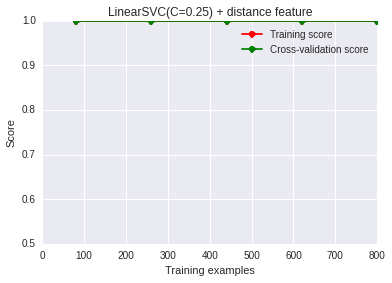

In [20]:
# add squared distance from origin as third feature
X_extra = np.hstack((X, X[:, [0]]**2 + X[:, [1]]**2))

plot_learning_curve(LinearSVC(C=0.25), "LinearSVC(C=0.25) + distance feature", 
                    X_extra, y, ylim=(0.5, 1.0),
                    train_sizes=np.linspace(.1, 1.0, 5))

Perfectly! But we had to invest some hard thinking (well, kind of) to come up with this feature. Maybe the classifier could do that kind of automatically? This requires to

 * **use more a complex model** (reduced regularization and/or non-linear kernel)

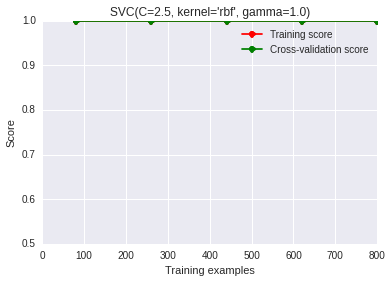

In [21]:
from sklearn.svm import SVC
# note: we use the original X without the extra feature
plot_learning_curve(SVC(C=2.5, kernel="rbf", gamma=1.0),
                    "SVC(C=2.5, kernel='rbf', gamma=1.0)",
                    X, y, ylim=(0.5, 1.0), 
                    train_sizes=np.linspace(.1, 1.0, 5))

Yes, that also works satisfactorily!

### Larger datasets and higher-dimensional feature spaces

Back to the original dataset, but this time with many more features and datapoints and 5 classes. LinearSVC would be a bit slow on this dataset size; the cheat sheet recommends using `SGDClassifier`. This classifier learns a linear model (just as `LinearSVC` or logistic regression) but uses stochastic gradient descent for training (just as artificial neural networks with backpropagation do typically). Note that `SGDClassifier` is sensitive to feature scaling and thus a common preprocessing on real datasets is to standardize the data with, e.g., `StandardScaler` such that every feature has mean 0 and variance 1.

`SGDClassifier` allows to sweep through the data in mini-batches, which is helpful when the data is too large to fit into memory. Cross-validation is not compatible with this technique; instead *progressive validation* is used: here, the estimator is tested always on the next chunk of training data (before seeing it for training). After training, it is tested again to check how well it has adapted to the data.

In [22]:
X, y = make_classification(200000, n_features=200, n_informative=25, 
                           n_redundant=0, n_classes=10, class_sep=2,
                           random_state=0)

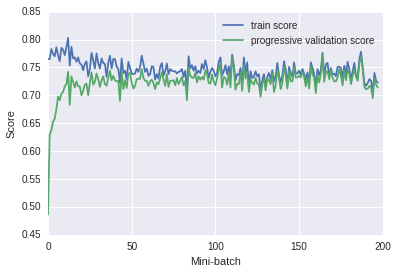

In [23]:
from sklearn.linear_model import SGDClassifier
est = SGDClassifier(penalty="l2", alpha=0.001)
progressive_validation_score = []
train_score = []
for datapoint in range(0, 199000, 1000):
    X_batch = X[datapoint:datapoint+1000]
    y_batch = y[datapoint:datapoint+1000]
    if datapoint > 0:
        progressive_validation_score.append(est.score(X_batch, y_batch))
    est.partial_fit(X_batch, y_batch, classes=range(10))
    if datapoint > 0:
        train_score.append(est.score(X_batch, y_batch))
    
plt.plot(train_score, label="train score")
plt.plot(progressive_validation_score, label="progressive validation score")
plt.xlabel("Mini-batch")
plt.ylabel("Score")
plt.legend(loc='best')

This plot tells us that after 50 mini-batches of data we are no longer improving on the validation data and could thus also stop training. Since the train score is not considerably larger, we are probably underfitting rather than overfitting. It would be nice to test an rbf kernel but `SGDClassifier` is unfortunately incompatible with the kernel trick. Alternatives would be to use a multi-layer perceptron, which can also be trained with stochastic gradient descent but is a non-linear model, or to use kernel-approximation, as suggested by the cheat-sheet. 

Now for one of the classic datasets used in machine learning, which deals with optical digit recognition: 

Dataset consist of 1083 samples with 64 features each


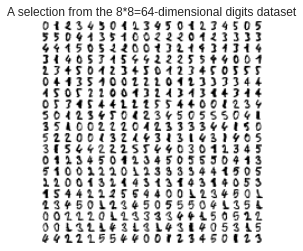

In [24]:
from sklearn.datasets import load_digits
digits = load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
print "Dataset consist of %d samples with %d features each" % (n_samples, n_features)

# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
_ = plt.title('A selection from the 8*8=64-dimensional digits dataset')

We have thus 1083 examples of hand-written digits (0, 1, 2, 3, 4, 5), where each of those consists of an $8 \times 8$ gray-scale image of 4-bit pixels (0, 16). The number of feature dimension is thus moderate (64); nevertheless, illustrating this 64-dimensional space is non-trivial. We illustrate different methods for reducing dimensionality (to two dimensions), based on http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#example-manifold-plot-lle-digits-py:

In [25]:
# <!-- collapse=True -->

# Helper function based on 
# http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#example-manifold-plot-lle-digits-py
from matplotlib import offsetbox
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 12})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Already a random projection of the data to two dimensions gives a not too bad impression:

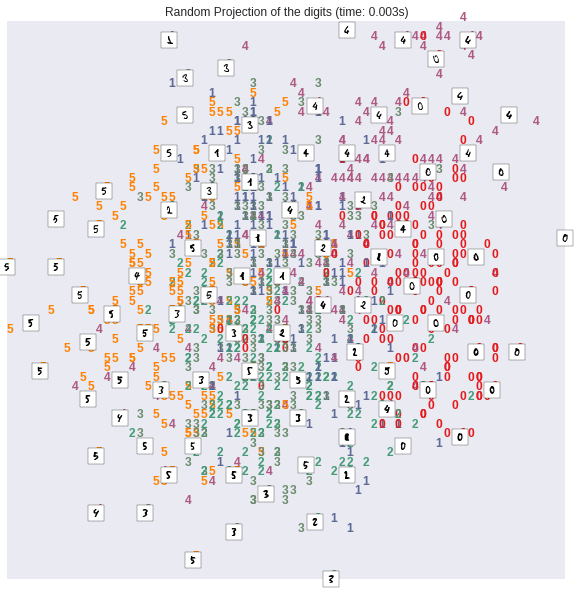

In [26]:
from sklearn import (manifold, decomposition, random_projection)
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
stime = time.time()
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Random Projection of the digits (time: %.3fs)" % (time.time() - stime))

However, there is a well-known technique that should be better suited in general, namely PCA (implemented using a TruncatedSVD which does not require constructing the covariance matrix):

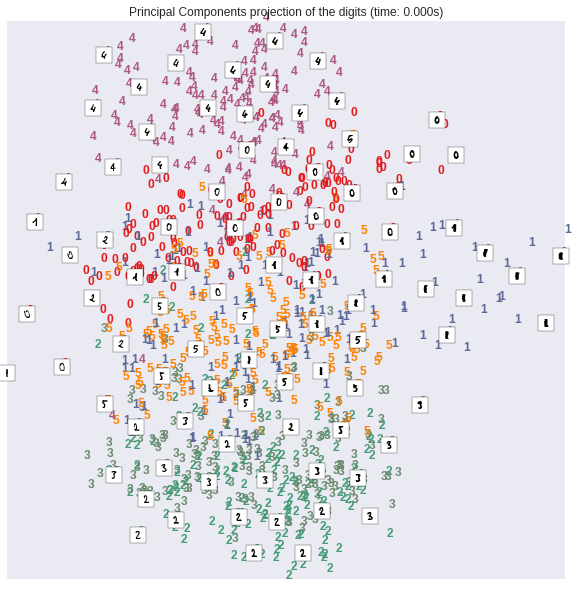

In [27]:
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
stime = time.time()
plot_embedding(X_pca,
               "Principal Components projection of the digits (time: %.3fs)" % (time.time() - stime))

PCA gives better results and is even faster on this dataset. We could do even better by allowing non-linear transformations from our 64-dimensional input space to the 2-dimensional target space. There exists many methods for this; we only present one of them here: t-SNE

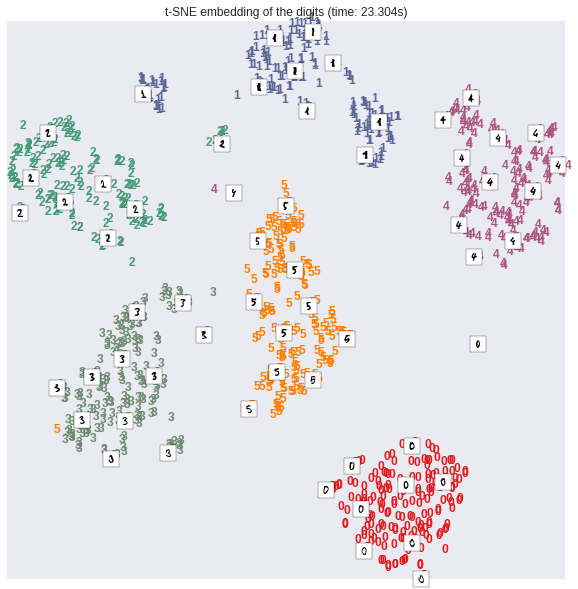

In [28]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
stime = time.time()
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time: %.3fs)" % (time.time() - stime))

Now this is a vastly superior embedding which also shows that it should be possible to separate these classes almost perfectly by a classifier (see, e.g., http://scikit-learn.org/stable/auto_examples/plot_digits_classification.html). The only disadvantage of t-SNE is that it takes considerably more time to be computed and thus does not scale to large datasets (in the current implementation).

### Choice of the loss function

The choice of the loss function is also quite important. Here is an illustration of different loss functions:

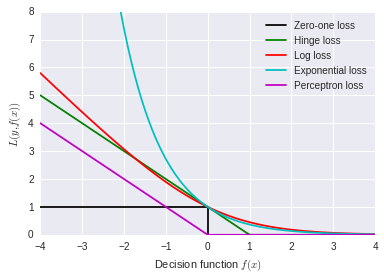

In [29]:
# adapted from http://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_loss_functions.html
xmin, xmax = -4, 4
xx = np.linspace(xmin, xmax, 100)
plt.plot([xmin, 0, 0, xmax], [1, 1, 0, 0], 'k-',
         label="Zero-one loss")
plt.plot(xx, np.where(xx < 1, 1 - xx, 0), 'g-',
         label="Hinge loss")
plt.plot(xx, np.log2(1 + np.exp(-xx)), 'r-',
         label="Log loss")
plt.plot(xx, np.exp(-xx), 'c-',
         label="Exponential loss")
plt.plot(xx, -np.minimum(xx, 0), 'm-',
         label="Perceptron loss")
# the balanced relative margin machine
#R = 2
#plt.plot(xx, np.where(xx < 1, 1 - xx, (np.where(xx > R, xx-R,0))), 'b-',
#         label="L1 Balanced Relative Margin Loss")
plt.ylim((0, 8))
plt.legend(loc="upper right")
plt.xlabel(r"Decision function $f(x)$")
plt.ylabel("$L(y, f(x))$")

The different loss functions have different advantages:

 * the zero-one loss is what you actually want in classification. Unfortunately it is non-convex and thus not practical since the optimization problem becomes more or less intractable
 * the hinge loss (used in support-vector classification) results in solutions which are sparse in the data (due to it being zero for $f(x) > 1$) and is relatively robust to outliers (it grows only linearly for $f(x)\to-\infty$) . It doesn't provide [well-calibrated probabilities](https://jmetzen.github.io/2014-08-16/reliability-diagram.html).
 * the log-loss (used, e.g., in logistic regression) results in well calibrated probabilities. It is thus the loss of choice if you don't want only binary predictions but also probabilities for the outcomes. On the downside, it's solutions are not sparse in the data space and it is more influenced by outliers than the hinge loss.
 * the exponential loss (used in [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost)) is very susceptible to outliers (due to its rapid increase when $f(x)\to-\infty$). It is primarily used in AdaBoost since it results there in a simple and efficient boosting algorithm.
 * the perceptron loss is basically a shifted version of the hinge loss. The hinge loss also penalizes points which are on the correct side of the boundary but very close to it (maximum-margin principle). The perceptron loss, on the other hand, is happy as long as a datapoint is on the correct side of the boundary, which leaves the boundary under-determined if the data is truly linearly separable and results in worse generalization than a maximum-margin boundary.

### Summary

We have discussed some recommendations of how to get machine learning working on a new problem. We have looked at classification problems but regression and clustering can be addressed similarly. Hoewever, the focus on artificial datasets was (while being easily to understand) also somewhat oversimplifying. On many actual problems, the collection, organisation, and preprocessing of the data are of uttermost importance. See for instance this article on [data wrangling](https://en.wikipedia.org/wiki/Data_wrangling). [pandas](http://pandas.pydata.org/) is a great tool for this. 

Many application domains also come with specific requirements and tools which are tailored to these demands, e.g.:

 * image-processing with [skimage](http://scikit-image.org/)
 * biosignal analysis and general time-series processing with [pySPACE](https://pyspace.github.io/pyspace/)
 * financial data with [pandas](http://pandas.pydata.org/) 
 
We don't explore these areas in detail; however, the effort that needs to be invested into a good pre-processing pipeline often exceeds the effort required for selecting an appropriate classifier considerably. A first impression of a moderately complex signal processing pipeline can be obtained from a pySPACE example for detecting a specific event-related potential in EEG data: https://github.com/pyspace/pyspace/blob/master/docs/examples/specs/node_chains/ref_P300_flow.yaml

This signal processing pipeline contains nodes for data standardization, decimation, band-pass filtering, dimensionality reduction (xDAWN is a supervised method for this), feature extraction (Local_Straightline_Features), and feature normalization. The following graphic gives an overview over different nodes in pySPACE that can be applied in a pipeline prior to classification:

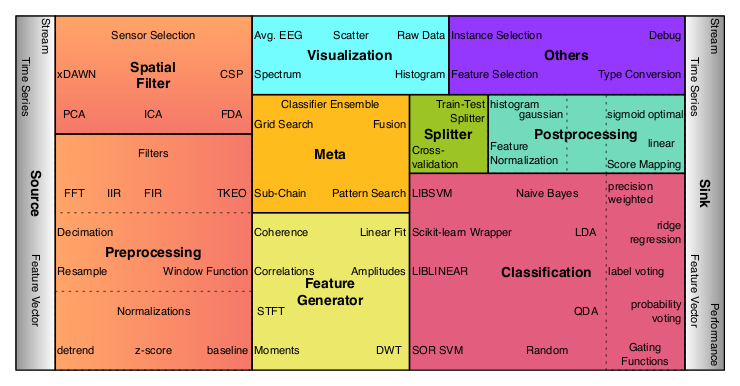

In [30]:
Image(filename='algorithm_types_detailed.png', width=800, height=600) 

One of the long-term goals of machine learning, which is pursued among others in the field of deep learning, is to allow to learn large parts of such pipelines rather than to hand-engineer them.

In [31]:
%load_ext watermark
%watermark -a "Jan Hendrik Metzen" -d -v -m -p numpy,scikit-learn

Jan Hendrik Metzen 29/01/2015 

CPython 2.7.9
IPython 2.1.0

numpy 1.9.1
scikit-learn 0.14.1

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 3.16.0-28-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
